In [1]:
import mlflow
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mlflow.set_tracking_uri('http://3.7.252.23:5000')

with mlflow.start_run():
    mlflow.log_param('param1', 5)
    mlflow.log_metric('metric1', 0.90)

2024/11/16 16:13:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run marvelous-crab-658 at: http://3.7.252.23:5000/#/experiments/0/runs/dc84c93ad0e2418eaa73b11da3650f0f.
2024/11/16 16:13:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://3.7.252.23:5000/#/experiments/0.


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
df.dropna(inplace=True)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [7]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/inductive_anks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/inductive_anks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [9]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [10]:
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [11]:
vectorizer = CountVectorizer(max_features=10000)

In [12]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category'] 

In [13]:
mlflow.set_experiment('RF Basline')

<Experiment: artifact_location='s3://youtube-mlflow-campusx/345959061862287631', creation_time=1731752845808, experiment_id='345959061862287631', last_update_time=1731752845808, lifecycle_stage='active', name='RF Basline', tags={}>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

2024/11/16 16:37:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/11/16 16:37:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_Baseline_Model at: http://3.7.252.23:5000/#/experiments/345959061862287631/runs/03871bfd0dee4159ae6c7531337e8ace.
2024/11/16 16:37:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://3.7.252.23:5000/#/experiments/345959061862287631.


Accuracy: 0.6412556053811659


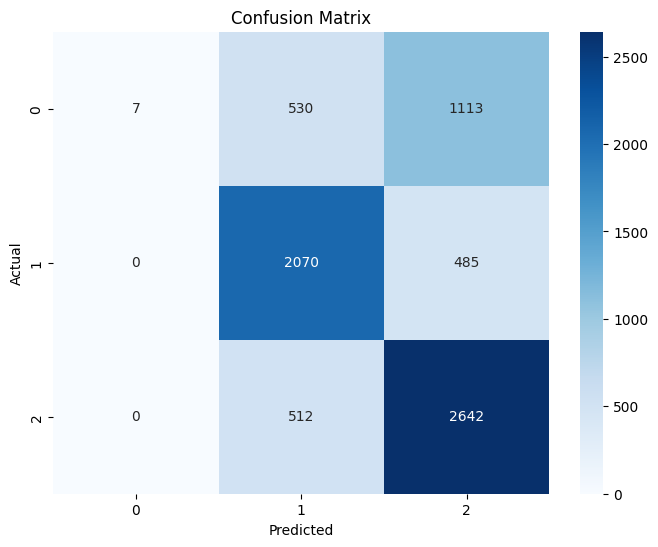

In [18]:
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag('mlflow.runName', 'RandomForest_Baseline_Model')
    mlflow.set_tag('experiment_type', 'baseline')
    mlflow.set_tag('model_type', 'RandomForestClassifier')
    
    # Add a description
    mlflow.set_tag('description', 'Baseline RandomForest model for sentiment analysis of youtube comments using Bag of Words')
    
    # Log parameters for the vectorizer
    mlflow.log_param('vectorizer_type', 'CountVectorizer')
    mlflow.log_param('vectorizer_max_features', vectorizer.max_features)
    
    # Log Random Forest Parameters
    n_estimators = 200
    max_depth = 15
    
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_param('max_depth', max_depth)
    
    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    
    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")